In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.base import BaseEstimator, TransformerMixin
import ast

# Load the data
data = pd.read_csv('case_study_data.csv')

In [49]:
# Specify the column
column_name = 'answers_wli_useAdWeightMedication'

# Print distinct non-null values
if column_name in data.columns:
    unique_values = data[column_name].dropna().unique()
    print(f"Distinct values in '{column_name}':")
    for val in unique_values:
        print(val)
else:
    print(f"Column '{column_name}' does not exist in the dataset.")

Column 'answers_wli_useAdWeightMedication' does not exist in the dataset.


In [50]:
import re


def parse_list_string(text):
    if not isinstance(text, str):
        return []

    # Find all '...' patterns
    matches = re.findall(r"'(.*?)'", text)
    return [m.strip() for m in matches if m.strip()]


def get_unique_item(source, column_name):
    all_items = set()
    # Print distinct non-null values
    if column_name in source.columns:
        unique_rows = source[column_name].dropna().unique()

        for row_t in unique_rows:
            list_t = parse_list_string(row_t)
            for item in list_t:
                all_items.add(item)
    else:
        print(f"Column '{column_name}' does not exist in the dataset.")
    return all_items

In [51]:
data.columns

Index(['answers_wli_start', 'answers_wli_currentlyUsingWeightMedication',
       'answers_wli_objective', 'answers_wli_usedWeightMedication',
       'answers_wli_height_feet', 'answers_wli_height_inches',
       'answers_wli_weight', 'answers_wli_pregnancyStatus',
       'answers_wli_medicalConditions', 'answers_wli_bloodWorkPast2Years',
       'answers_wli_bloodWorkNormal', 'answers_wli_eatingDisorder',
       'answers_wli_eatingDisorderDetails', 'answers_wli_bloodPressure',
       'answers_wli_weightLossSurgery', 'answers_wli_triedLosingWeight',
       'answers_wli_triedLosingWeightDetails', 'answers_wli_concernsHowLong',
       'answers_wli_diet', 'answers_wli_exerciseFrequency',
       'answers_wli_affectingHealth', 'answers_wli_treatmentGoals',
       'answers_wli_lifestyle', 'answers_wli_allergiesListed',
       'answers_wli_confirmValidInfo', 'answers_wli_sex',
       'answers_wli_ethnicity', 'answers_wli_comorbidities',
       'answers_wli_contraIndications', 'answers_wli_contr

In [ ]:
class WLIDataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, train_data,handle_target=True):
        self.train_data = train_data
        # self.bmi_min = bmi_min
        # self.bmi_max = bmi_max
        # self.outlier_method = outlier_method
        self.handle_target = handle_target

        # if self.outlier_method not in ['clip', 'remove', 'winsorize']:
        #     raise ValueError("outlier_method must be 'clip', 'remove', or 'winsorize'")

        self.drop_columns = [
            'answers_wli_start', 'answers_wli_objective', 'answers_wli_bloodPressure',
            'answers_wli_eatingDisorderDetails', 'ingestionTimestamp',
            'providerID', 'userID', 'id',
            'answers_wli_confirmValidInfo',
            'answers_wli_medicalConditions',
            'answers_wli_eatingDisorder',
        ]

        self.list_columns = [
            'answers_wli_weightLossSurgery', 'answers_wli_triedLosingWeight',
            'answers_wli_treatmentGoals', 'answers_wli_lifestyle',
            'answers_wli_comorbidities', 'answers_wli_contraIndications',
            'answers_wli_contraIndicationsMental', 'answers_wli_pregnancyStatus'
        ]

        self.ordinal_columns = [
            'answers_wli_concernsHowLong', 'answers_wli_diet',
            'answers_wli_exerciseFrequency', 'answers_wli_affectingHealth'
        ]

        self.categorical_columns = [
            'answers_wli_ethnicity'
        ]

        self.binary_columns = [
            'answers_wli_currentlyUsingWeightMedication', 'answers_wli_usedWeightMedication',
            'answers_wli_bloodWorkPast2Years', 'answers_wli_bloodWorkNormal',
            'answers_wli_sex', 'isHighPriority'
        ]

        self.text_columns = ['answers_wli_triedLosingWeightDetails']

        self.ordinal_columns_options = {
            'answers_wli_concernsHowLong': [
                'Less than 6 months', '6-12 months', '1-5 years', 'More than 5 years'
            ],
            'answers_wli_diet': [
                'Very unhealthy', 'Somewhat unhealthy', 'Neither healthy or unhealthy', 'Somewhat healthy',
                'Very healthy'
            ],
            'answers_wli_exerciseFrequency': [
                'I do not exercise', '1 day per week', '2 days per week', '3 days per week', '4 or more days per week'
            ],
            'answers_wli_affectingHealth': [
                'No, not at all', 'No, not much', 'Yes, somewhat', 'Yes, a lot'
            ]
        }

        

        self.list_columns_options = {}
        self.categorical_columns_options = {}

        self._collect_info()

    def _collect_info(self):
        for column in self.list_columns:
            option_set = get_unique_item(self.train_data, column)
            self.list_columns_options[column] = option_set

        for column in self.categorical_columns:
            option_set = set(self.train_data[column].dropna().unique())
            self.categorical_columns_options[column] = option_set

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        df = X.copy()
        df.drop(columns=[col for col in self.drop_columns if col in df.columns], inplace=True, errors='ignore')
        result = pd.DataFrame(index=df.index)

        result["height_total_inches"] = df["answers_wli_height_feet"] * 12 + df["answers_wli_height_inches"]
        result["weight"] = df["answers_wli_weight"]
        result["BMI"] = result["weight"] / (result["height_total_inches"] ** 2) * 703.0717

        for column in self.list_columns:
            col_prefix = column.replace("answers_wli_", "")
            for item in self.list_columns_options[column]:
                result[f"{col_prefix}__{item}"] = df[column].apply(
                    lambda x: int(item in re.findall(r"'(.*?)'", x)) if isinstance(x, str) else 0
                )

        result["mh_disorder_count"] = (
                result.get("contraIndicationsMental__Depression or bipolar disorder", 0) +
                result.get("contraIndicationsMental__History of depression", 0) +
                result.get("contraIndicationsMental__Anxiety disorder, such as generalized anxiety disorder (GAD), panic disorder, or obsessive compulsive disorder (OCD)",
                    0)
        )

        result.drop(columns=[
            'contraIndicationsMental__Depression or bipolar disorder',
            'contraIndicationsMental__History of depression',
            'contraIndicationsMental__Anxiety disorder, such as generalized anxiety disorder (GAD), panic disorder, or obsessive compulsive disorder (OCD)'
        ], inplace=True, errors='ignore')

        for column in self.ordinal_columns:
            short_col = column.replace("answers_wli_", "")
            categories = self.ordinal_columns_options[column]
            category_map = {val: i for i, val in enumerate(categories)}
            result[short_col] = df[column].map(category_map).fillna(-1).astype(int)

        for column in self.categorical_columns:
            short_col = column.replace("answers_wli_", "")
            for val in self.categorical_columns_options[column]:
                result[f"{short_col}__{val}"] = df[column].apply(lambda x: int(x == val))

        for column in self.binary_columns:
            short_col = column.replace("answers_wli_", "")
            result[short_col] = df[column].map({"Yes": 1, "No": 0, "Male": 1, "Female": 0, True: 1, False: 0}).fillna(
                -1).astype(int)

        result["weight_comorbidity_count"] = (
                result.get("comorbidities__Sleep apnea", 0) +
                result.get("comorbidities__High blood pressure (Hypertension)", 0) +
                result.get("comorbidities__High cholesterol (Hyperlipidemia)", 0) +
                result.get('comorbidities__High triglycerides (Hypertriglyceridemia)', 0) +
                result.get('comorbidities__Polycystic ovary syndrome (PCOS)', 0)
        )

        result.drop(columns=[
            'comorbidities__Sleep apnea',
            'comorbidities__High blood pressure (Hypertension)',
            'comorbidities__High cholesterol (Hyperlipidemia)',
            'comorbidities__High triglycerides (Hyperlipidemia)',
            'comorbidities__Polycystic ovary syndrome (PCOS)'
        ], inplace=True, errors='ignore')

        result["blocking_contra_count"] = (
                result.get('contraIndications__Multiple Endocrine Neoplasia Type 2', 0) +
                result.get('contraIndications__Chronic liver or kidney disease', 0) +
                result.get('contraIndications__History of medullary thyroid cance', 0) +
                result.get('contraIndications__Opioid use or opioid agonist use (methadone/buprenorphine)', 0) +
                result.get('contraIndications__Pancreatitis', 0)
        )

        result.drop(columns=[
            'contraIndications__Multiple Endocrine Neoplasia Type 2',
            'contraIndications__Chronic liver or kidney disease',
            'contraIndications__History of medullary thyroid cance',
            'contraIndications__Opioid use or opioid agonist use (methadone/buprenorphine)',
            'contraIndications__Pancreatitis'
        ], inplace=True, errors='ignore')

        # TODO result shows that this does not distinguish the target at all
        # result['eligible_for_weight_loss_meds'] = (
        #         (result["BMI"] > 35) |
        #         ((result["BMI"] > 30) & (result["weight_comorbidity_count"] > 0) &
        #          result.get("weightLossSurgery__None of the below", 0) &
        #          result.get("contraIndications__None of the below", 0))
        # ).astype(int)

        failed_keywords = [
            "not working", "not very effective", "not effective", "not at all", "didn't.*work", "did not work",
            "short term", "weight came back", "rebounded", "temporary", "struggled", "slipping", "no matter how much"
        ]

        result["failed_diet_or_exercise_efforts"] = df["answers_wli_triedLosingWeightDetails"].astype(
            str).str.lower().apply(
            lambda x: int(any(re.search(kw, x) for kw in failed_keywords))
        )

        if self.handle_target and "status" in df.columns:
            result["status"] = df["status"].map({"approved": 1, "declined": 0}).fillna(-1).astype(int)

        return result

    # def _handle_bmi_outliers(self, result):
    #     if self.outlier_method == 'clip':
    #         result['BMI'] = result['BMI'].clip(lower=self.bmi_min, upper=self.bmi_max)
    #         return result
    #     elif self.outlier_method == 'remove':
    #         mask = (result['BMI'] >= self.bmi_min) & (result['BMI'] <= self.bmi_max)
    #         return result[mask]
    #     elif self.outlier_method == 'winsorize':
    #         lower = result['BMI'].quantile(0.01)
    #         upper = result['BMI'].quantile(0.99)
    #         result['BMI'] = result['BMI'].clip(lower=max(lower, self.bmi_min), upper=min(upper, self.bmi_max))
    #         return result

In [53]:
preprocessor = WLIDataPreprocessor(train_data=data, outlier_method='remove')
df = preprocessor.transform(data)

print(df.columns)
df.describe()

Index(['height_total_inches', 'weight', 'BMI',
       'weightLossSurgery__Laparoscopic adjustable gastric band (Lap-Band)',
       'weightLossSurgery__Other procedure',
       'weightLossSurgery__None of the below',
       'weightLossSurgery__Roux-en-Y gastric bypass',
       'weightLossSurgery__Gastric balloon',
       'weightLossSurgery__Sleeve gastrectomy', 'triedLosingWeight__Exercise',
       'triedLosingWeight__Other',
       'triedLosingWeight__Weight loss supplements or over-the-counter products',
       'triedLosingWeight__Commercial weight loss plan (eg. Weight Watchers, Jenny Craig)',
       'triedLosingWeight__None of the below',
       'triedLosingWeight__Specialized diet (eg. Low calorie, Paleo, Atkins, Keto, Ornish)',
       'triedLosingWeight__Therapy or counselling',
       'triedLosingWeight__Prescription weight loss medication',
       'triedLosingWeight__Laxatives or diuretics',
       'triedLosingWeight__Working with a dietitian', 'treatmentGoals__Other',
       't

,height_total_inches,weight,BMI,weightLossSurgery__Laparoscopic adjustable gastric band (Lap-Band),weightLossSurgery__Other procedure,weightLossSurgery__None of the below,weightLossSurgery__Roux-en-Y gastric bypass,weightLossSurgery__Gastric balloon,weightLossSurgery__Sleeve gastrectomy,triedLosingWeight__Exercise,...,currentlyUsingWeightMedication,usedWeightMedication,bloodWorkPast2Years,bloodWorkNormal,sex,isHighPriority,weight_comorbidity_count,blocking_contra_count,failed_diet_or_exercise_efforts,status
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.0000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,65.765900,206.377000,33.409691,0.004900,0.007300,0.959300,0.010500,0.002000,0.017200,0.828900,...,0.051300,0.053000,0.673900,0.2745,0.127600,0.002800,0.427400,0.00840,0.450900,0.500000
std,3.519764,42.377688,5.535793,0.069832,0.085132,0.197604,0.101935,0.044679,0.130023,0.376615,...,0.223771,0.388595,0.471573,0.9115,0.488203,0.052844,0.720265,0.10065,0.497608,0.500025
min,50.000000,109.000000,23.045534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.0000,-1.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,63.000000,178.000000,29.986196,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,-1.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,65.000000,199.000000,31.930159,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,1.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.500000
75%,68.000000,230.000000,35.665708,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,1.0000,0.000000,0.000000,1.000000,0.00000,1.000000,1.000000
max,82.000000,745.000000,123.973590,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,5.000000,4.00000,1.000000,1.000000


In [54]:
# # count how many ppl are eligible for weight loss medications
# eligible_count = df['eligible_for_weight_loss_meds'].sum()
# print(f"Number of patients eligible for weight loss medications: {eligible_count}")
# #  check how many patients are approved for weight loss medications
# data['status'].map({'approved': 1, 'declined': 0})
# print(
#     f"Number of patients approved for weight loss medications: {data['status'].map({'approved': 1, 'declined': 0}).sum()}")
# 
# count = df[(df["eligible_for_weight_loss_meds"] == 1) & (df["status"] == 1)].shape[0]
# print(f"Eligible and Approved Patients: {count}")

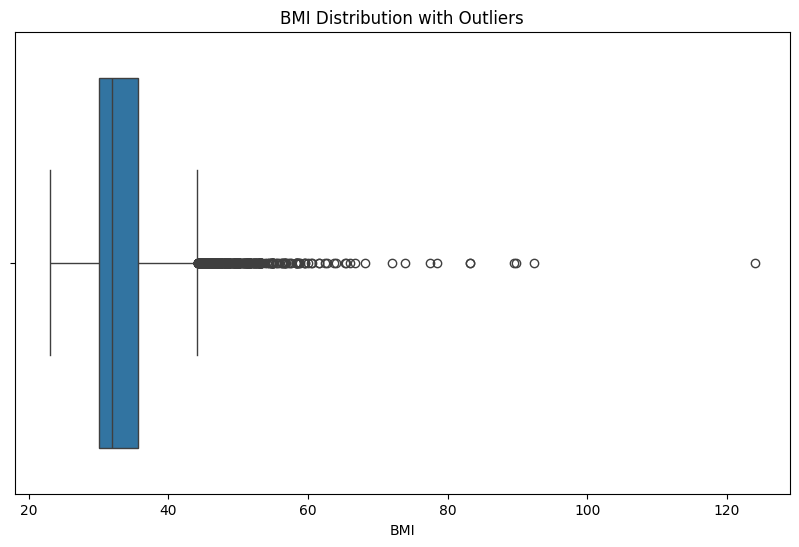

Number of BMI outliers: 476


In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize BMI distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['BMI'])
plt.title('BMI Distribution with Outliers')
plt.show()

# Calculate outlier bounds using IQR
Q1 = df['BMI'].quantile(0.25)
Q3 = df['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['BMI'] < lower_bound) | (df['BMI'] > upper_bound)]
print(f"Number of BMI outliers: {len(outliers)}")

In [56]:
def remove_outliers_iqr(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


# Example usage for BMI
df = remove_outliers_iqr(df, 'BMI')

In [80]:
y = df['status']
X_transformed = df.drop(columns=['status', 'weight'], errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.1, random_state=42, stratify=y)

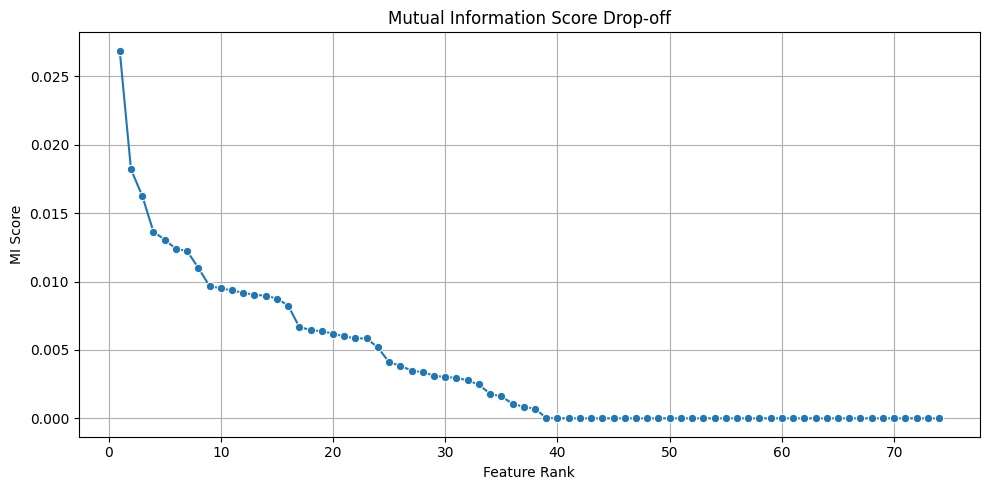

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

# Assume selector has been fit already and scores_ is available
mi_scores_all = mutual_info_classif(X_train, y_train, random_state=42)
feature_names_all = X_train.columns

# Sort scores and names together
sorted_indices = np.argsort(mi_scores_all)[::-1]
sorted_scores = mi_scores_all[sorted_indices]
sorted_features = feature_names_all[sorted_indices]

# Plot MI scores ranked by importance
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(1, len(sorted_scores) + 1), y=sorted_scores, marker='o')
plt.title("Mutual Information Score Drop-off")
plt.xlabel("Feature Rank")
plt.ylabel("MI Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [93]:

selector = SelectKBest(score_func=mutual_info_classif, k=30)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_feature_names = X_train.columns[selector.get_support()]

print(selected_feature_names)

Index(['height_total_inches', 'BMI',
       'weightLossSurgery__Laparoscopic adjustable gastric band (Lap-Band)',
       'weightLossSurgery__Sleeve gastrectomy',
       'triedLosingWeight__Weight loss supplements or over-the-counter products',
       'triedLosingWeight__Commercial weight loss plan (eg. Weight Watchers, Jenny Craig)',
       'triedLosingWeight__Working with a dietitian', 'treatmentGoals__Other',
       'lifestyle__I use recreational drugs',
       'comorbidities__None of the below',
       'comorbidities__Fatty liver disease',
       'comorbidities__Family History of Type 2 Diabetes',
       'contraIndications__Diabetes (Type 2)',
       'contraIndications__Seizures or epilepsy',
       'contraIndications__None of the below',
       'contraIndications__History of medullary thyroid cancer',
       'contraIndications__Diabetes (Type 1)',
       'contraIndications__History of delayed gastric emptying, or gastroparesis',
       'contraIndicationsMental__Alcohol use disorder

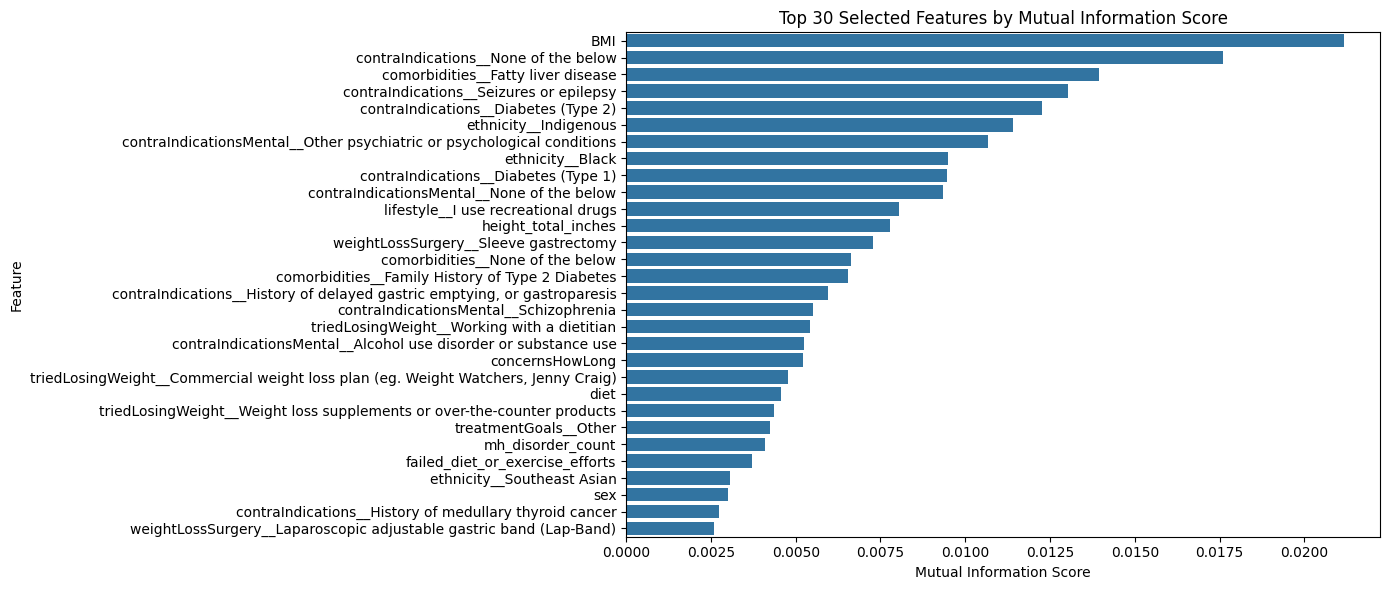

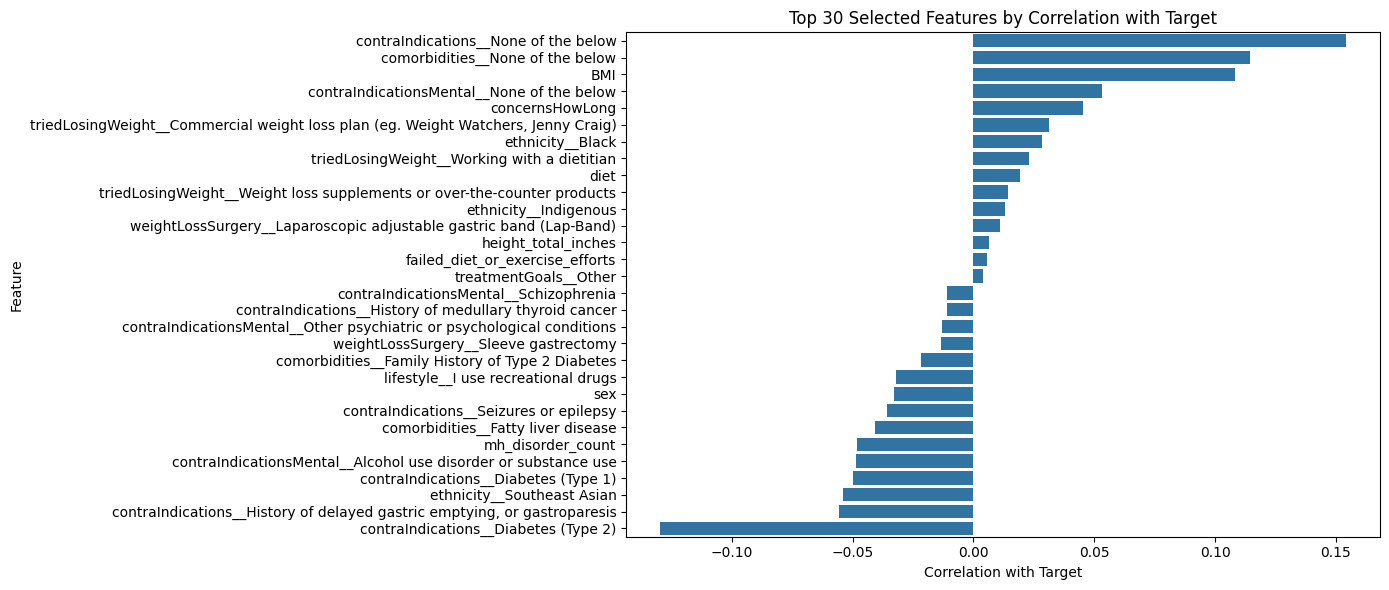

In [94]:
mi_scores = selector.scores_[selector.get_support()]

correlations = []

for feat in selected_feature_names:
    col = X_train[feat]
    if col.std() == 0 or col.isnull().any():
        correlations.append(0.0)  # or np.nan if you want to mark it
    else:
        corr = col.corr(y_train)
        correlations.append(corr)

# Combine both
feature_summary = pd.DataFrame({
    "Feature": selected_feature_names,
    "Mutual Information Score": mi_scores,
    "Correlation with Target": correlations
}).sort_values("Mutual Information Score", ascending=False)

# Plot: Mutual Information
plt.figure(figsize=(14, 6))
sns.barplot(x="Mutual Information Score", y="Feature", data=feature_summary)
plt.title("Top 30 Selected Features by Mutual Information Score")
plt.tight_layout()
plt.show()

# Plot: Correlation
plt.figure(figsize=(14, 6))
sns.barplot(x="Correlation with Target", y="Feature",
            data=feature_summary.sort_values("Correlation with Target", ascending=False))
plt.title("Top 30 Selected Features by Correlation with Target")
plt.tight_layout()
plt.show()

In [78]:
def approval_rate(y_pred):
    return np.mean(y_pred) * 100  # Multiply by 100 for percentage


In [83]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    n_estimators=5000,
    learning_rate=0.001,
    max_depth=3,
    random_state=42,
    verbose=-1
)
model.fit(X_train_selected, y_train)

# Predict label and confidence (probability of approval)
y_val_pred = model.predict(X_test_selected)
y_val_proba = model.predict_proba(X_test_selected)[:, 1]

# Evaluate 
print("🔎 Accuracy:", accuracy_score(y_test, y_val_pred))
print("🎯 AUC Score:", roc_auc_score(y_test, y_val_proba))

print(f"Approval Rate: {approval_rate(y_val_pred):.2f}%")
print(classification_report(y_test, y_val_pred))


🔎 Accuracy: 0.5991605456453305
🎯 AUC Score: 0.6330730405369694
Approval Rate: 67.16%
              precision    recall  f1-score   support

           0       0.65      0.43      0.52       477
           1       0.57      0.77      0.66       476

    accuracy                           0.60       953
   macro avg       0.61      0.60      0.59       953
weighted avg       0.61      0.60      0.59       953



C:\Users\zzhul\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\zzhul\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [88]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=500,
    max_depth=3,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_selected, y_train)

y_val_pred = model.predict(X_test_selected)
y_val_proba = model.predict_proba(X_test_selected)[:, 1]

y_tst = model.predict(X_train_selected)
print(" RF Accuracy:", accuracy_score(y_train, y_tst))

print("🔎 RF Accuracy:", accuracy_score(y_test, y_val_pred))
print("🎯 RF AUC:", roc_auc_score(y_test, y_val_proba))

print(f"Approval Rate: {approval_rate(y_val_pred):.2f}%")
print(classification_report(y_test, y_val_pred))


 RF Accuracy: 0.6134640065336601
🔎 RF Accuracy: 0.5855194123819517
🎯 RF AUC: 0.6198756232052569
Approval Rate: 68.73%
              precision    recall  f1-score   support

           0       0.64      0.40      0.49       477
           1       0.56      0.77      0.65       476

    accuracy                           0.59       953
   macro avg       0.60      0.59      0.57       953
weighted avg       0.60      0.59      0.57       953



In [ ]:
from xgboost import XGBClassifier

# n=7000, k=30, lr=0.001, max_d=6, sub=0.6, col_sub=0.9

model_xgb = XGBClassifier(
    n_estimators=7000,
    learning_rate=0.001,
    max_depth=6,
    random_state=42,
    verbosity=0,
    subsample=0.6,
    colsample_bytree=0.9,
)
model_xgb.fit(X_train_selected, y_train)




y_val_pred = model_xgb.predict(X_test_selected)
y_val_proba = model_xgb.predict_proba(X_test_selected)[:, 1]


from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_val_proba)
best_threshold = thresholds[np.argmax(2 * (precision * recall) / (precision + recall))]

# Predict with new threshold
y_pred_adjusted = (y_val_proba >= best_threshold).astype(int)
print("🔎 XGBoost Accuracy:", accuracy_score(y_test, y_pred_adjusted))
# print("🎯 XGBoost AUC:", roc_auc_score(y_test, y_val_proba))

print(f"Approval Rate: {approval_rate(y_pred_adjusted):.2f}%")
print(classification_report(y_test, y_pred_adjusted))


🔎 XGBoost Accuracy: 0.5844700944386149
🎯 XGBoost AUC: 0.6181183165089935
Approval Rate: 61.49%
              precision    recall  f1-score   support

           0       0.61      0.47      0.53       477
           1       0.57      0.70      0.63       476

    accuracy                           0.58       953
   macro avg       0.59      0.58      0.58       953
weighted avg       0.59      0.58      0.58       953

🔎 XGBoost Accuracy: 0.5949632738719832
Approval Rate: 79.12%
              precision    recall  f1-score   support

           0       0.73      0.30      0.43       477
           1       0.56      0.89      0.69       476

    accuracy                           0.59       953
   macro avg       0.64      0.60      0.56       953
weighted avg       0.64      0.59      0.56       953



In [86]:
# Hyperparameter tuning for XGBoost
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [1000, 3000, 5000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.001, 0.005, 0.01],
    'subsample': [0.6, 0.7],
    'colsample_bytree': [0.8, 0.9]
}

xgb_model = XGBClassifier(random_state=42, verbosity=0)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(X_train_selected, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
print(f"Best Parameters: {best_params}")
print(f"Best Accuracy Score: {best_score:.4f}")
y_val_pred = best_model.predict(X_test_selected)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.7}
Best Accuracy Score: 0.6150


In [66]:
# Calculate metrics
print(f"Approval Rate: {approval_rate(y_val_pred):.2f}%")
# print(f"False Approval Rate: {false_approval_rate(y, y_val_pred, contraindication_mask):.2f}%")

# Confusion matrix for context
# tn, fp, fn, tp = confusion_matrix(y, y_val_pred).ravel()
# print(f"False Approvals (FP): {fp}")

Approval Rate: 66.11%


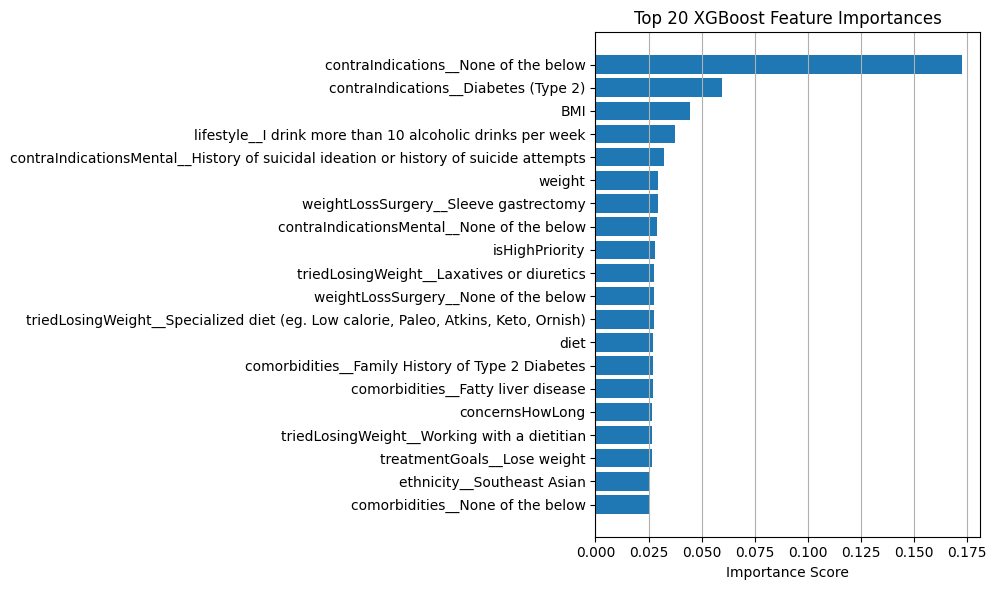

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances and match them to column names
importances = model_xgb.feature_importances_

selected_feature_names = X_train.columns[selector.get_support()]

importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top N features
TOP_N = 20
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(TOP_N)[::-1], importance_df['Importance'].head(TOP_N)[::-1])
plt.xlabel("Importance Score")
plt.title(f"Top {TOP_N} XGBoost Feature Importances")
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()


In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Step 2: Define the MLP model
model = MLPClassifier(
    hidden_layer_sizes=(32, 64, 128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate='constant',
    max_iter=3000,
    early_stopping=True,  # Stops if val score doesn't improve
    random_state=42
)

# Step 3: Train
model.fit(X_train_scaled, y_train)

# Step 4: Predict
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Step 5: Evaluate
print("🔎 MLP Accuracy:", accuracy_score(y_test, y_pred))
print("🎯 MLP AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_val_pred))

🔎 MLP Accuracy: 0.5571878279118573
🎯 MLP AUC: 0.5852822260979864
              precision    recall  f1-score   support

           0       0.63      0.43      0.51       477
           1       0.57      0.75      0.65       476

    accuracy                           0.59       953
   macro avg       0.60      0.59      0.58       953
weighted avg       0.60      0.59      0.58       953

